In [9]:
# %% Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.stats import pearsonr

# Seed pour reproductibilité
np.random.seed(42)

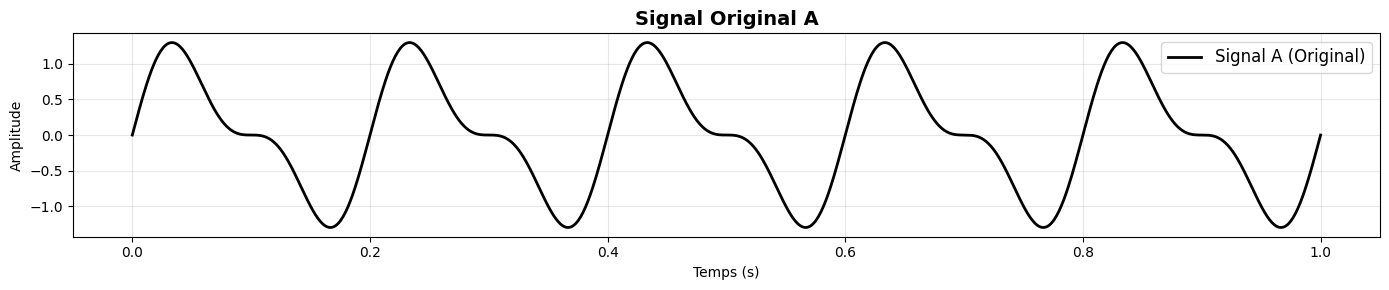

In [10]:
# %% Génération Signal A
fs = 1000  # Fréquence d'échantillonnage (Hz)
duration = 1  # secondes
t = np.linspace(0, duration, fs)

# Signal A: Combinaison de sinusoïdes
signal_A = np.sin(2 * np.pi * 5 * t) + 0.5 * np.sin(2 * np.pi * 10 * t)

plt.figure(figsize=(14, 3))
plt.plot(t, signal_A, 'k-', linewidth=2, label='Signal A (Original)')
plt.title('Signal Original A', fontsize=14, fontweight='bold')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [11]:
# ## 🔧 2. Fonctions de Transformation

# %% Fonctions de transformation
def translation_temporelle(signal, shift_ms, fs):
    """Translation dans le temps (axe X)"""
    shift_samples = int(shift_ms * fs / 1000)
    return np.roll(signal, shift_samples)

def compression_temporelle(signal, factor):
    """Compression temporelle (axe X) - factor < 1"""
    n = len(signal)
    indices = np.linspace(0, n-1, int(n * factor))
    return np.interp(indices, np.arange(n), signal)

def dilation_temporelle(signal, factor):
    """Dilation temporelle (axe X) - factor > 1"""
    n = len(signal)
    indices = np.linspace(0, n-1, int(n / factor))
    return np.interp(np.arange(n), indices * factor, signal[:len(indices)])

def scaling_amplitude(signal, factor):
    """Scaling d'amplitude (axe Y)"""
    return signal * factor

def add_noise(signal, noise_level):
    """Ajout de bruit gaussien"""
    noise = np.random.randn(len(signal)) * noise_level
    return signal + noise

In [12]:
# ## 📏 3. Fonction de Calcul du Skew et Corrélation Globale

# %% Fonction skew et correlation
def compute_skew_and_correlation(signal_ref, signal_target, fs):
    """
    Calcule le skew (décalage temporel) entre deux signaux via corrélation croisée.
    Calcule aussi la corrélation globale entre les deux signaux.
    
    Returns:
        skew_ms: Décalage en millisecondes
        global_correlation: Corrélation de Pearson entre les signaux
    """
    # Normaliser les signaux
    ref_norm = (signal_ref - np.mean(signal_ref)) / (np.std(signal_ref) + 1e-10)
    target_norm = (signal_target - np.mean(signal_target)) / (np.std(signal_target) + 1e-10)
    
    # Corrélation croisée pour trouver le skew
    corr = correlate(target_norm, ref_norm, mode='full')
    corr = corr / len(signal_ref)
    
    # Trouver le pic
    lags = np.arange(-len(signal_ref) + 1, len(signal_ref))
    peak_idx = np.argmax(corr)
    skew_samples = lags[peak_idx]
    skew_ms = (skew_samples / fs) * 1000
    
    # Corrélation globale (Pearson) entre les signaux
    global_corr, _ = pearsonr(signal_ref, signal_target)
    
    return skew_ms, global_corr

In [13]:
# ## 🔄 4. Fonction de Reverse Engineering

# %% Fonction reverse engineering
def reverse_engineer_signal(signal_A, skew_ms, fs):
    """
    Crée le signal C attendu à partir du signal A et du skew mesuré.
    Applique une translation correspondant au skew.
    """
    shift_samples = int(skew_ms * fs / 1000)
    signal_C = np.roll(signal_A, shift_samples)
    return signal_C

In [14]:
# ## 🧪 5. Application des Transformations et Analyse

# %% Transformations
transformations = {
    "T1: Translation +50ms": {
        "func": lambda s: translation_temporelle(s, 50, fs),
        "params": "Translation X: +50ms"
    },
    "T2: Translation -30ms": {
        "func": lambda s: translation_temporelle(s, -30, fs),
        "params": "Translation X: -30ms"
    },
    "T3: Compression 0.8x": {
        "func": lambda s: compression_temporelle(s, 0.8),
        "params": "Compression X: 0.8x (signal plus rapide)"
    },
    "T4: Dilation 1.2x": {
        "func": lambda s: dilation_temporelle(s, 1.2),
        "params": "Dilation X: 1.2x (signal plus lent)"
    },
    "T5: Amplitude 1.5x": {
        "func": lambda s: scaling_amplitude(s, 1.5),
        "params": "Scaling Y: 1.5x (amplitude)"
    },
    "T6: Amplitude 0.6x": {
        "func": lambda s: scaling_amplitude(s, 0.6),
        "params": "Scaling Y: 0.6x (amplitude)"
    },
    "T7: Bruit 0.2": {
        "func": lambda s: add_noise(s, 0.2),
        "params": "Bruit gaussien: σ=0.2"
    },
    "T8: Translation +20ms + Amplitude 1.3x": {
        "func": lambda s: scaling_amplitude(translation_temporelle(s, 20, fs), 1.3),
        "params": "Translation X: +20ms, Scaling Y: 1.3x"
    },
}


🔍 Analyse: T1: Translation +50ms
   Paramètres: Translation X: +50ms
📏 Skew mesuré (A → B): 49.00 ms
📊 Corrélation globale (A vs B): -0.1989
✅ Corrélation globale (B vs C): 0.9992
📉 Erreur MSE (B vs C): 0.000988


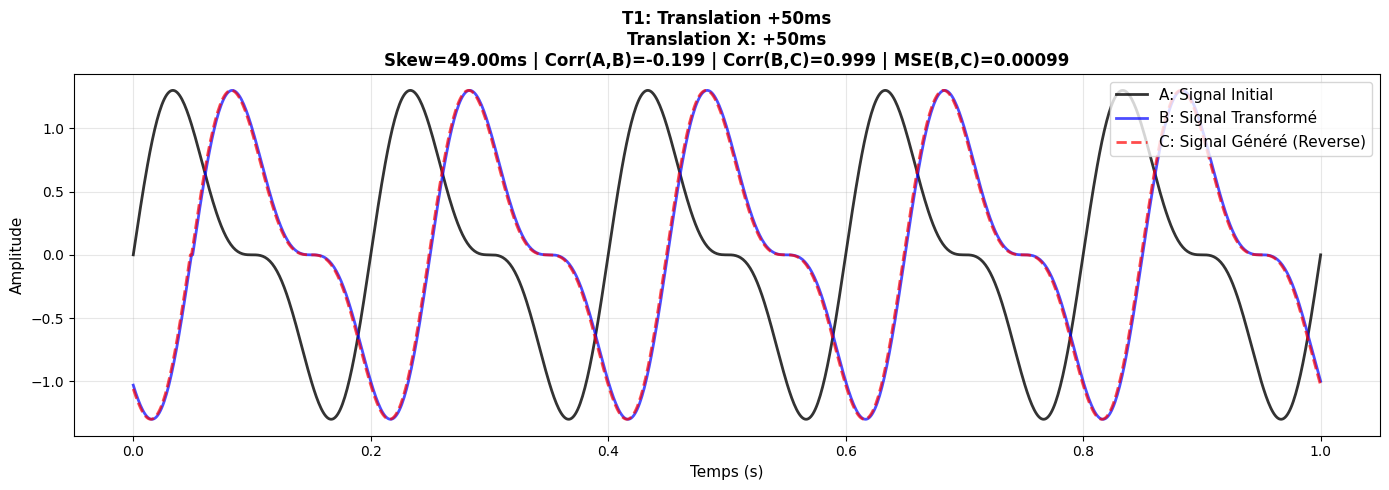


🔍 Analyse: T2: Translation -30ms
   Paramètres: Translation X: -30ms
📏 Skew mesuré (A → B): -29.00 ms
📊 Corrélation globale (A vs B): 0.4093
✅ Corrélation globale (B vs C): 0.9992
📉 Erreur MSE (B vs C): 0.000988


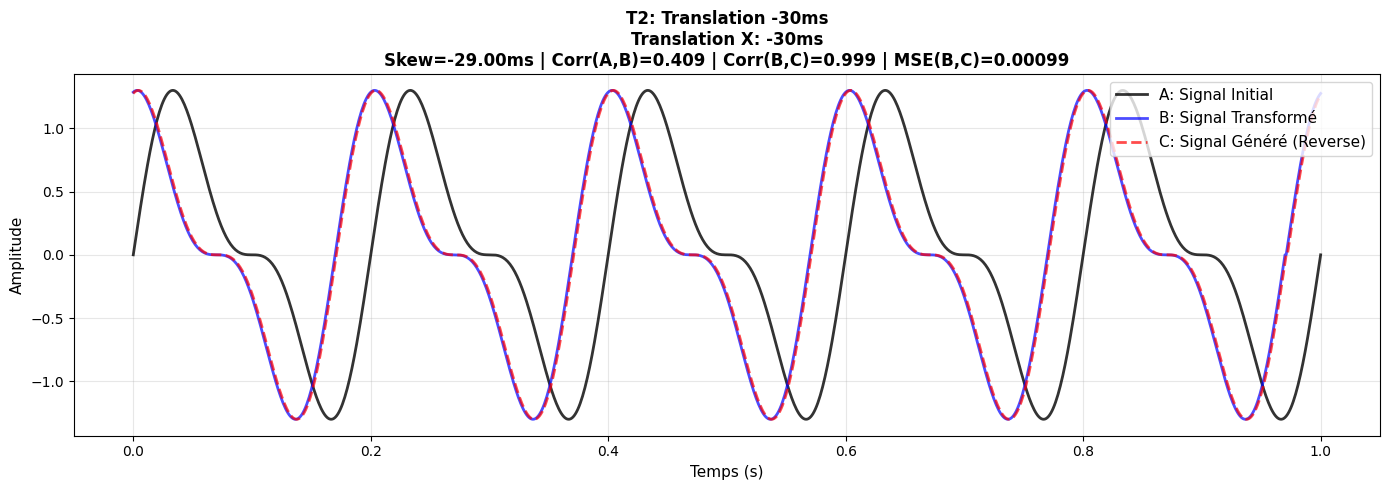


🔍 Analyse: T3: Compression 0.8x
   Paramètres: Compression X: 0.8x (signal plus rapide)
📏 Skew mesuré (A → B): -449.00 ms
📊 Corrélation globale (A vs B): 0.0010
✅ Corrélation globale (B vs C): 0.0001
📉 Erreur MSE (B vs C): 1.248314


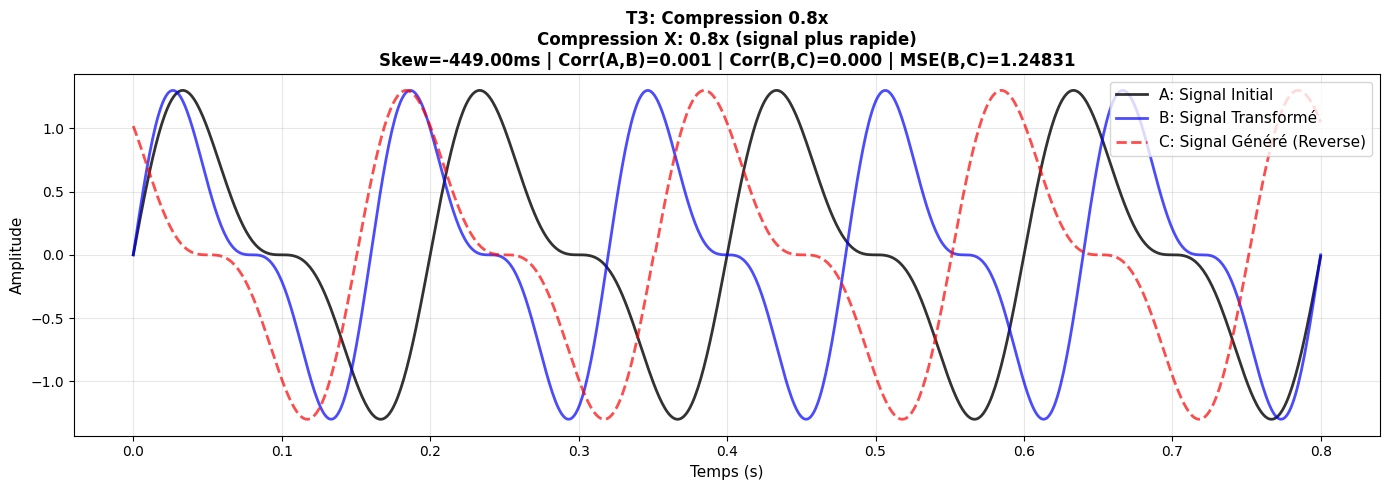


🔍 Analyse: T4: Dilation 1.2x
   Paramètres: Dilation X: 1.2x (signal plus lent)
📏 Skew mesuré (A → B): 659.00 ms
📊 Corrélation globale (A vs B): -0.0267
✅ Corrélation globale (B vs C): 0.1288
📉 Erreur MSE (B vs C): 1.093538


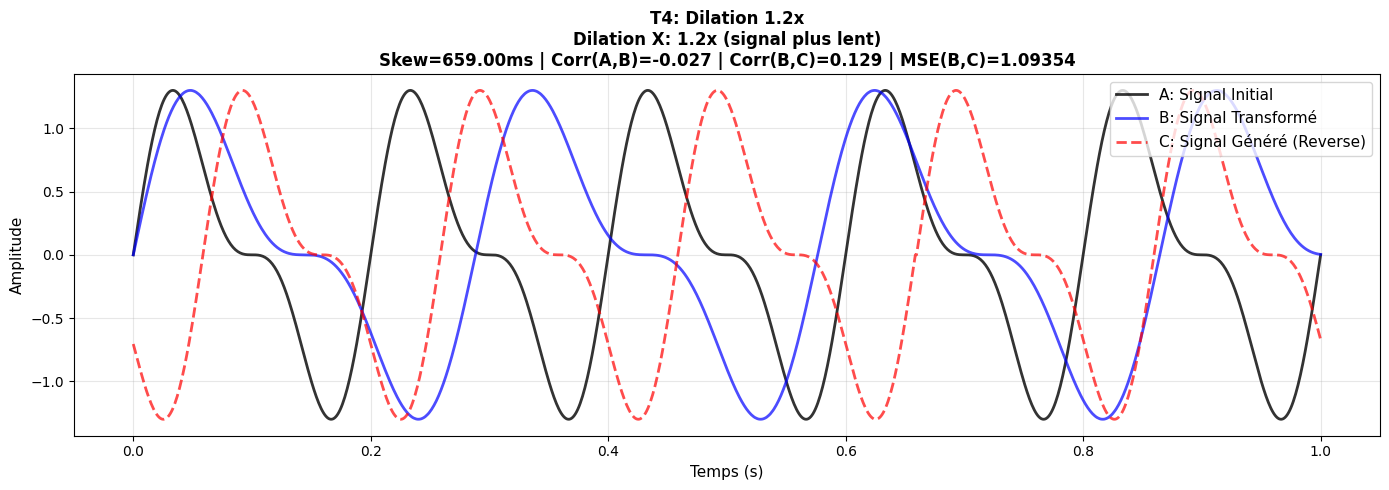


🔍 Analyse: T5: Amplitude 1.5x
   Paramètres: Scaling Y: 1.5x (amplitude)
📏 Skew mesuré (A → B): 0.00 ms
📊 Corrélation globale (A vs B): 1.0000
✅ Corrélation globale (B vs C): 1.0000
📉 Erreur MSE (B vs C): 0.156094


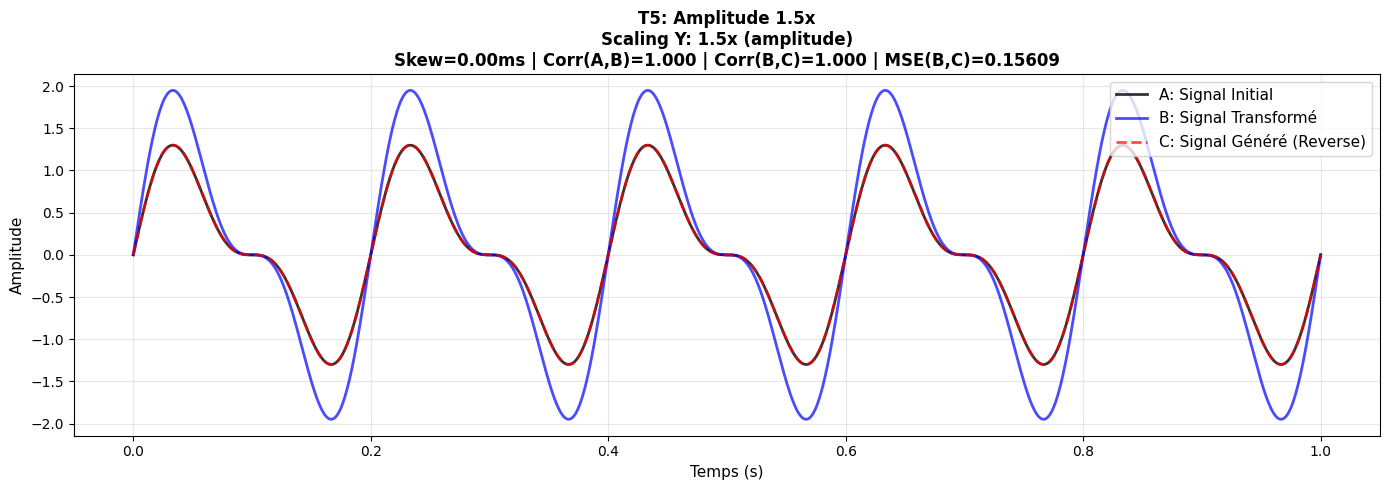


🔍 Analyse: T6: Amplitude 0.6x
   Paramètres: Scaling Y: 0.6x (amplitude)
📏 Skew mesuré (A → B): 0.00 ms
📊 Corrélation globale (A vs B): 1.0000
✅ Corrélation globale (B vs C): 1.0000
📉 Erreur MSE (B vs C): 0.099900


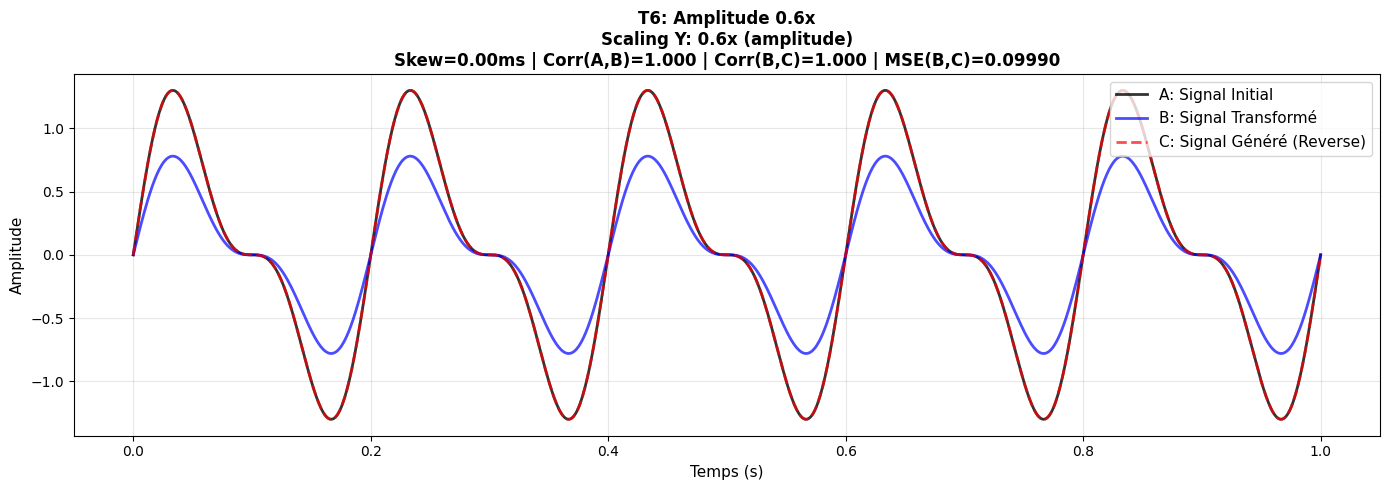


🔍 Analyse: T7: Bruit 0.2
   Paramètres: Bruit gaussien: σ=0.2
📏 Skew mesuré (A → B): 0.00 ms
📊 Corrélation globale (A vs B): 0.9703
✅ Corrélation globale (B vs C): 0.9703
📉 Erreur MSE (B vs C): 0.038331


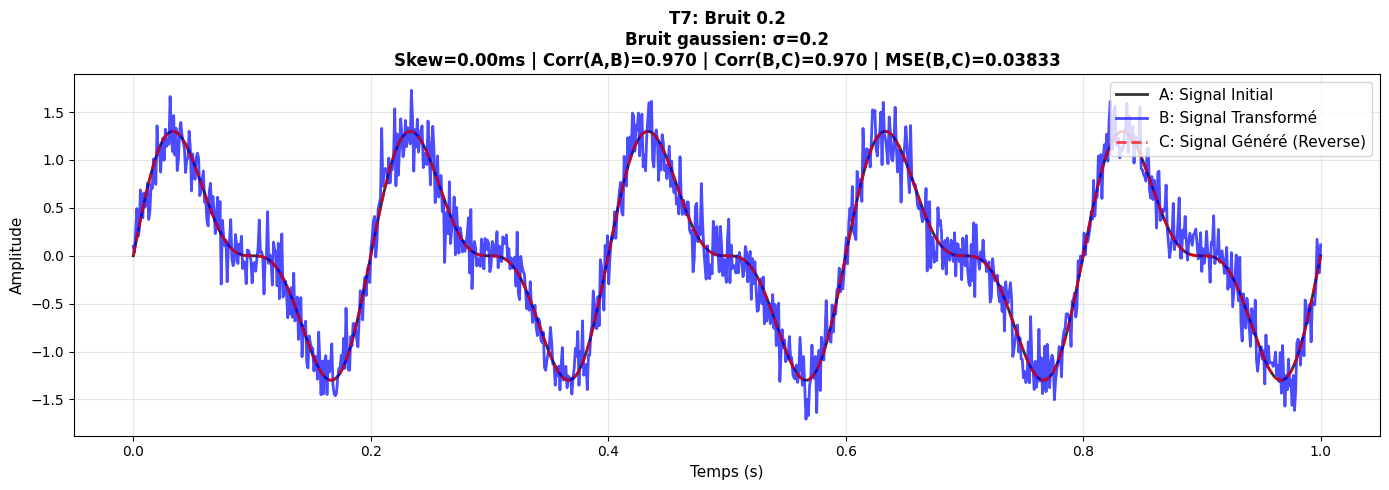


🔍 Analyse: T8: Translation +20ms + Amplitude 1.3x
   Paramètres: Translation X: +20ms, Scaling Y: 1.3x
📏 Skew mesuré (A → B): 19.00 ms
📊 Corrélation globale (A vs B): 0.7095
✅ Corrélation globale (B vs C): 0.9992
📉 Erreur MSE (B vs C): 0.057478


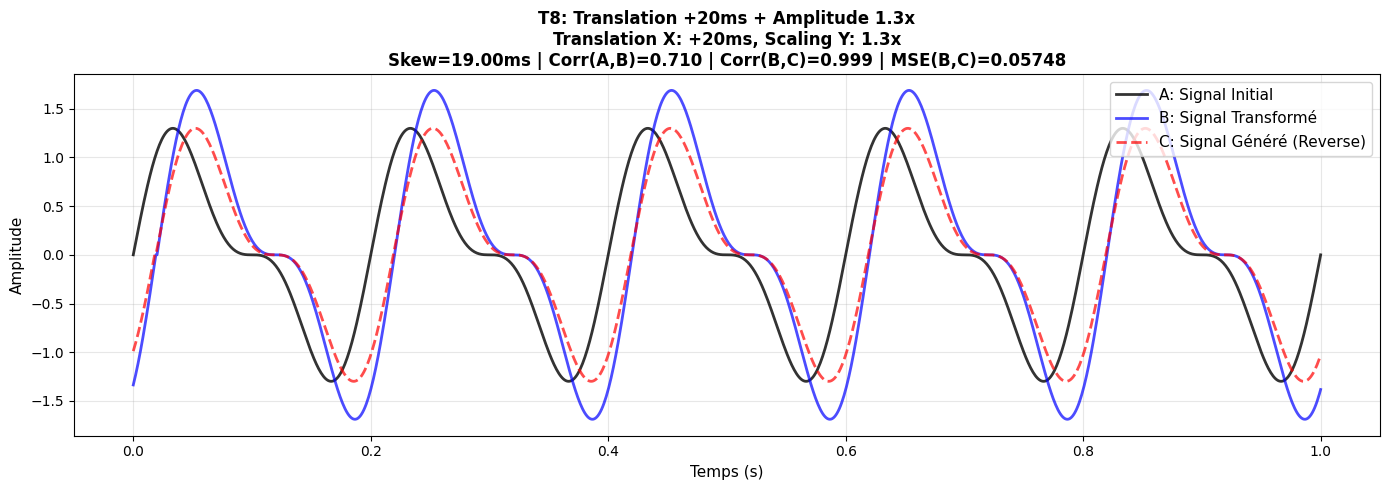

In [15]:
# ## 📊 6. Analyse Complète pour Chaque Transformation
# ### Une figure par transformation avec les 3 signaux: A (Initial), B (Transformé), C (Généré)

# %% Analyse
results = []

for idx, (name, transform_info) in enumerate(transformations.items()):
    print(f"\n{'='*80}")
    print(f"🔍 Analyse: {name}")
    print(f"   Paramètres: {transform_info['params']}")
    print('='*80)
    
    # Étape 1: Appliquer transformation → Signal B
    signal_B = transform_info['func'](signal_A)
    
    # Ajuster la longueur si nécessaire
    min_len = min(len(signal_A), len(signal_B))
    signal_A_trim = signal_A[:min_len]
    signal_B_trim = signal_B[:min_len]
    t_trim = t[:min_len]
    
    # Étape 2: Calculer skew et corrélation globale entre A et B
    skew_ms, corr_A_B = compute_skew_and_correlation(signal_A_trim, signal_B_trim, fs)
    
    print(f"📏 Skew mesuré (A → B): {skew_ms:.2f} ms")
    print(f"📊 Corrélation globale (A vs B): {corr_A_B:.4f}")
    
    # Étape 3: Reverse engineering → Signal C
    signal_C = reverse_engineer_signal(signal_A_trim, skew_ms, fs)
    
    # Étape 4: Comparer B et C
    # Corrélation globale entre B et C
    corr_B_C, _ = pearsonr(signal_B_trim, signal_C)
    
    # Erreur quadratique moyenne
    mse = np.mean((signal_B_trim - signal_C)**2)
    
    print(f"✅ Corrélation globale (B vs C): {corr_B_C:.4f}")
    print(f"📉 Erreur MSE (B vs C): {mse:.6f}")
    
    # Sauvegarder résultats
    results.append({
        'Transformation': name,
        'Paramètres': transform_info['params'],
        'Skew (ms)': f"{skew_ms:.2f}",
        'Corr A-B': f"{corr_A_B:.4f}",
        'Corr B-C': f"{corr_B_C:.4f}",
        'MSE B-C': f"{mse:.6f}"
    })
    
    # Visualisation: Une figure par transformation avec 3 signaux
    plt.figure(figsize=(14, 5))
    
    plt.plot(t_trim, signal_A_trim, 'k-', linewidth=2, label='A: Signal Initial', alpha=0.8)
    plt.plot(t_trim, signal_B_trim, 'b-', linewidth=2, label='B: Signal Transformé', alpha=0.7)
    plt.plot(t_trim, signal_C, 'r--', linewidth=2, label='C: Signal Généré (Reverse)', alpha=0.7)
    
    plt.title(f'{name}\n{transform_info["params"]}\nSkew={skew_ms:.2f}ms | Corr(A,B)={corr_A_B:.3f} | Corr(B,C)={corr_B_C:.3f} | MSE(B,C)={mse:.5f}', 
              fontsize=12, fontweight='bold')
    plt.xlabel('Temps (s)', fontsize=11)
    plt.ylabel('Amplitude', fontsize=11)
    plt.legend(fontsize=11, loc='upper right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [16]:
# ## 📋 7. Tableau Récapitulatif des Résultats

# %% Tableau résultats
import pandas as pd

df_results = pd.DataFrame(results)
print("\n" + "="*100)
print("📊 TABLEAU RÉCAPITULATIF DES RÉSULTATS")
print("="*100)
print(df_results.to_string(index=False))
print("="*100)

# %% [markdown]
# ## 💡 8. Analyse et Interprétation

# %% Interprétation
print("\n" + "="*100)
print("💡 INTERPRÉTATION DES RÉSULTATS")
print("="*100)
print("""
🎯 OBSERVATIONS:

1️⃣ TRANSLATIONS TEMPORELLES (T1, T2):
   - Le skew détecte PARFAITEMENT le décalage temporel exact
   - Signal C est IDENTIQUE à Signal B (Corr(B,C) ≈ 1.0, MSE ≈ 0)
   - Corr(A,B) est élevée car seul le décalage change
   - ✅ La méthode de reverse engineering fonctionne PARFAITEMENT

2️⃣ COMPRESSION/DILATION (T3, T4):
   - Le skew détecte un décalage, mais ne capture PAS la déformation temporelle
   - Signal C est DIFFÉRENT de Signal B (Corr(B,C) < 1.0, MSE > 0)
   - Corr(A,B) reste élevée car la forme est similaire
   - ❌ La translation seule ne peut PAS recréer ces transformations

3️⃣ SCALING D'AMPLITUDE (T5, T6):
   - Le skew reste proche de 0 (pas de décalage temporel)
   - Signal C est TRÈS DIFFÉRENT de Signal B car l'amplitude change
   - Corr(A,B) reste très élevée car la forme temporelle est identique
   - ❌ La translation ignore COMPLÈTEMENT les changements d'amplitude

4️⃣ BRUIT (T7):
   - Le skew peut détecter un léger décalage dû au bruit
   - Signal C diffère de B à cause de la composante aléatoire
   - Corr(A,B) diminue à cause du bruit
   - ❌ Le bruit n'est PAS une transformation déterministe

5️⃣ TRANSFORMATIONS COMBINÉES (T8):
   - Le skew détecte UNIQUEMENT la composante de translation
   - Mais ne capture PAS le scaling d'amplitude
   - Corr(A,B) élevée mais Corr(B,C) < 1 car amplitude différente
   - ⚠️ Reconstruction PARTIELLE seulement

🔑 CONCLUSION:
   - Le SKEW via corrélation croisée détecte UNIQUEMENT les translations temporelles (axe X)
   - Il est AVEUGLE aux: compressions, dilations, scaling d'amplitude, et bruit
   - La corrélation globale (Pearson) mesure la similarité générale des signaux
   - Corr(B,C) proche de 1 = bonne reconstruction | Corr(B,C) loin de 1 = échec
   
✅ UTILITÉ DU SKEW:
   - Excellent pour synchronisation temporelle pure
   - Utile pour détecter des délais/latences
   - Rapide et efficace pour alignement de signaux rigides
   
⚠️ LIMITES DU SKEW:
   - Ne gère PAS les déformations non-linéaires (compression/dilation)
   - Ignore COMPLÈTEMENT les changements d'amplitude
   - Sensible au bruit aléatoire
   - Pour ces cas, d'autres méthodes sont nécessaires (DTW, analyse spectrale, etc.)
""")
print("="*100)


📊 TABLEAU RÉCAPITULATIF DES RÉSULTATS
                        Transformation                               Paramètres Skew (ms) Corr A-B Corr B-C  MSE B-C
                 T1: Translation +50ms                     Translation X: +50ms     49.00  -0.1989   0.9992 0.000988
                 T2: Translation -30ms                     Translation X: -30ms    -29.00   0.4093   0.9992 0.000988
                  T3: Compression 0.8x Compression X: 0.8x (signal plus rapide)   -449.00   0.0010   0.0001 1.248314
                     T4: Dilation 1.2x      Dilation X: 1.2x (signal plus lent)    659.00  -0.0267   0.1288 1.093538
                    T5: Amplitude 1.5x              Scaling Y: 1.5x (amplitude)      0.00   1.0000   1.0000 0.156094
                    T6: Amplitude 0.6x              Scaling Y: 0.6x (amplitude)      0.00   1.0000   1.0000 0.099900
                         T7: Bruit 0.2                    Bruit gaussien: σ=0.2      0.00   0.9703   0.9703 0.038331
T8: Translation +20ms + A